In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

sys.path.append('../bitome-kb/')
from pathlib import Path
from bitome.core import Bitome
from math import log,exp,inf
bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')

In [2]:
import ast
im_info = pd.read_csv('data/precise2_im_info_new.csv')

IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )
IM_genes.keys()

dict_keys(['CysB-1', 'HprR+CusR', 'PhoB-1', 'Fnr-1', 'TdcAR', 'Fimbriae', 'PurR-2', 'Fnr+NarL', 'GalRS', 'BtsR', 'PyrR', 'PlaR', 'RpoN+FhlA', 'RhaS', 'NanR', 'FadR', 'NrdR', 'GlcC', 'BaeR+CpxR', 'NikR', 'Isoleucine', 'RpoN+PspF', 'OxyR', 'TrpR', 'CsqR', 'LldR', 'Thiamine-1', 'PuuR', 'YcjW', 'PdhR+OmpR', 'NsrR', 'GntR', 'Fnr+NarLP', 'RcsAB', 'MalT', 'TyrR', 'Molybdopterin', 'Fnr-2', 'AtoC', 'Leucine', 'SoxS', 'Translation', 'RcnR', 'Lrp', 'Nac', 'KdpE', 'PhoB-2', 'RbsR', 'CysB-2', 'FlhDC-1', 'GatR', 'ArgR', 'GadX', 'RpoN+NtrC-1', 'XylR', 'ArcA', 'BirA', 'EvgA', 'BluR', 'LsrR', 'Zur', 'RpoE', 'Fur-1', 'PurR-1', 'ArgP', 'AllR', 'FucR', 'Fur-2', 'Mlc', 'CecR', 'Fnr+IHF+gcvB', 'YgbI', 'LexA', 'Cra', 'GlpR', 'RpoN+NtrC-2', 'PaaX', 'Oligopeptide', 'CdaR', 'RpoN+PrpR+Cra', 'FliA', 'CpxR', 'Histidine', 'RpoH', 'GadE+FliZ', 'GcvA', 'YdeO+H-NS', 'NagC', 'GutM+SrlR', 'MetJ', 'RpoS', 'CysB-3', 'FlhDC-2', 'RutR', 'PhoP', 'RyhB', 'BasR', 'NarL', 'RpoS+ArgR+RpoN', 'Crp-related-2'])

In [3]:
features = pd.read_csv('features_avg.csv')
S = pd.read_csv('data/S.csv')

In [4]:
features.columns

Index(['ID', 'strand', 'TU_length', 'leading', 'lagging', 'terminus',
       'Sigma70_Prib_Start', 'Sigma70_Prib_score', 'Sigma70_Prib_hmd',
       'Sigma70_Prib_Tm',
       ...
       'EP_TSS_1', 'EP_TSS_2', 'EP_TSS_3', 'EP_TSS_4', 'EP_TSS_5', 'EP_TSS_6',
       'EP_TSS_7', 'EP_TSS_8', 'EP_TSS_9', 'EP_TSS_10'],
      dtype='object', length=2192)

In [5]:
featureList = list(features.columns[1:2192])
X = features.iloc[:,1:].values
X = StandardScaler().fit_transform(X)
ID = list(features['ID'])

In [6]:
# cobvert gene name and b number.
b_g = {}
for g in bitome.genes:
    b_g[g.name] = g.locus_tag

In [7]:
# old version of IM genes
img = {}
for im in bitome.i_modulons:
    img[im.name] = []
    for g in im.genes:
            img[im.name].append( g.locus_tag)

# classify im membership

In [8]:
target_labels={}
for r in IM_genes.keys():
    target_labels[r] = []
    for i in range( len(ID) ):
        if ID[i] in IM_genes[r]:
            target_labels[r].append( 1 )
        else:
            target_labels[r].append( 0 ) 

In [9]:
models_to_try = {
    'LR': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        random_state=42
    ),
    'SVM': LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        random_state=42,
        verbose=1
    ),
    'RF': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        verbose=1
    )
}

In [10]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(
            solver='saga',
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'C': np.arange(0.01, 5, 0.05)
        }
    },
    'SVM': {
        'model': LinearSVC(
            class_weight='balanced',
            dual=False,
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'loss': ['hinge', 'squared_hinge'],
            'C': np.arange(0.01, 5, 0.05)
        }
    },
    'RF': {
        'model': RandomForestClassifier(
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'n_estimators': np.arange(10, 100, 5 ),
            'max_depth': np.arange(3, 15),
            'min_samples_split': np.arange(0.001, 0.02, 0.001),
            'min_samples_leaf': np.arange(5, 15)
        }
    }
}

In [13]:
y_to_try_1 = {
    'Fnr+IHF+gcvB':target_labels['Fnr+IHF+gcvB'], 'Fnr+NarL':target_labels['Fnr+NarL'],
    'Fnr+NarLP':target_labels['Fnr+NarLP'],'Fnr-1':target_labels['Fnr-1'],'Fnr-2':target_labels['Fnr-2'],
    'Fur-1':target_labels['Fur-1'], 'Fur-2':target_labels['Fur-2'],'GadE+FliZ':target_labels['GadE+FliZ'],
    'GadX':target_labels['GadX'], 'GalRS':target_labels['GalRS'],'GatR':target_labels['GatR'],
    'GlpR':target_labels['GlpR'], 'GcvA':target_labels['GcvA'], 'GntR':target_labels['GntR'],
    'Leucine':target_labels['Leucine'],'LexA':target_labels['LexA']
}

In [14]:
hyperopt_RF = {}

for y_name, y_labels in y_to_try_1.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['RF']['model'],
        hyperopt_models['RF']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_RF[y_name] = hyperopt_results_df

Fnr+IHF+gcvB
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   56.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fnr+NarL
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fnr+NarLP
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   59.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fnr-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fnr-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fur-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fur-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


GadE+FliZ
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


GadX
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


GalRS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   51.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


GatR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


GlpR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   55.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.1s finished
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


GcvA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [15]:
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_RF.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)
    
hyperopt_RF_df_1 = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_RF_df_1.to_csv('data/hyperopt_RF_1.csv')

Text(0.5, 1.0, 'RF')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


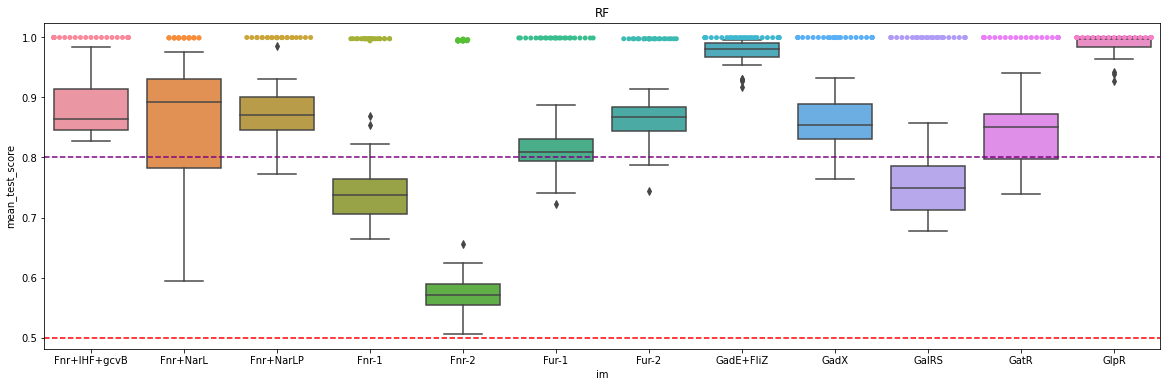

In [16]:
hyperopt_RF_df_1=pd.read_csv('data/hyperopt_RF_1.csv')
plt.figure( figsize=(20,6))
sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_RF_df_1)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_RF_df_1)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'purple', ls = '--')
plt.title('RF')

Text(0.5, 1.0, 'RF')

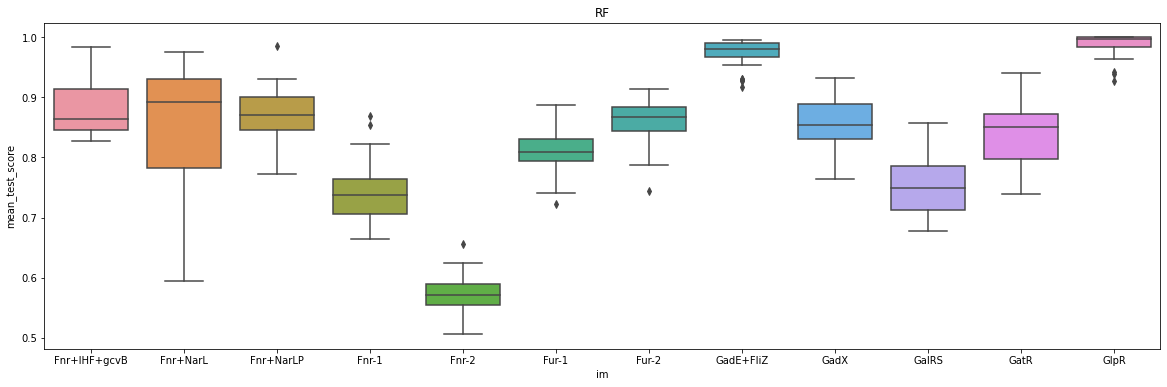

In [17]:
plt.figure( figsize=(20,6))
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_RF_df_1)
plt.title('RF')

In [18]:
y_to_try_2 = {
    'OxyR':target_labels['OxyR'], 'LexA':target_labels['LexA'],'NsrR':target_labels['NsrR'],
    'Lrp':target_labels['Lrp'],'MalT':target_labels['MalT'],'Mlc':target_labels['Mlc'],
    'MetJ':target_labels['MetJ'],'Nac':target_labels['Nac'], 'NagC':target_labels['NagC'],
    'NanR':target_labels['NanR'], 'NarL':target_labels['NarL'],'NrdR':target_labels['NrdR'],
    'PaaX':target_labels['PaaX'],'PhoB-1':target_labels['PhoB-1'],'PhoB-2':target_labels['PhoB-2'],
    'PhoP':target_labels['PhoP'],'PurR-1':target_labels['PurR-1'],'PurR-2':target_labels['PurR-2']
}

In [19]:
hyperopt_RF = {}

for y_name, y_labels in y_to_try_2.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['RF']['model'],
        hyperopt_models['RF']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_RF[y_name] = hyperopt_results_df

OxyR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LexA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


NsrR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Lrp
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   32.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


MalT
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   58.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Mlc
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   55.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


MetJ
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Nac
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   53.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


NagC
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


NanR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   47.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


NarL
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   53.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


NrdR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   49.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


PaaX
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


PhoB-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


PhoB-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


PhoP
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


PurR-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


PurR-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   44.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.3s finished


In [20]:
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_RF.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)
    
hyperopt_RF_df_2 = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_RF_df_2.to_csv('data/hyperopt_RF_2.csv')

Text(0.5, 1.0, 'RF')

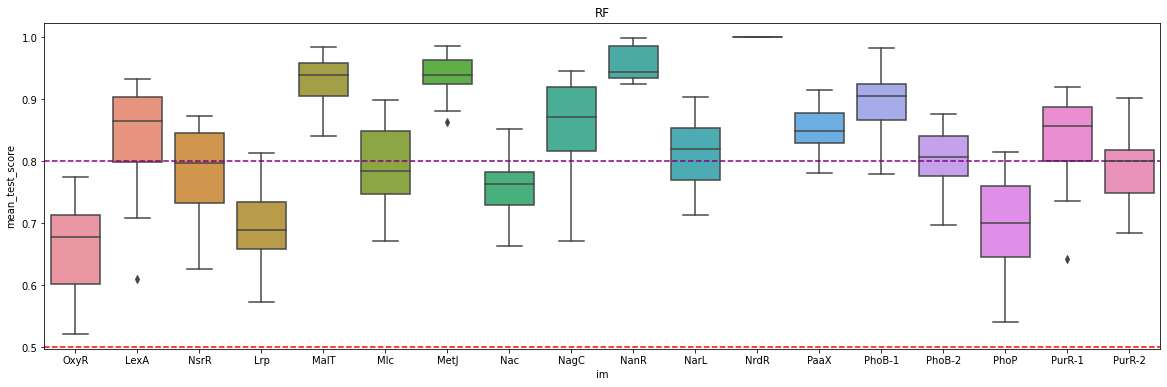

In [31]:
hyperopt_RF_df_2 = pd.read_csv('data/hyperopt_RF_2.csv')
plt.figure( figsize=(20,6))
#sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_RF_df_2)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_RF_df_2)
plt.axhline(y= 0.8, color = 'purple', ls = '--')
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.title('RF')

In [22]:
y_to_try_3 = {
    'PuuR':target_labels['PuuR'],'RcsAB':target_labels['RcsAB'], 'RhaS':target_labels['RhaS'],
    'RpoE':target_labels['RpoE'], 'RpoH':target_labels['RpoH'], 'RpoN+FhlA':target_labels['RpoN+FhlA'],
    'RpoN+NtrC-1':target_labels['RpoN+NtrC-1'],'RpoN+NtrC-2':target_labels['RpoN+NtrC-2'],
    'RpoN+PrpR+Cra':target_labels['RpoN+PrpR+Cra'],'RpoN+PspF':target_labels['RpoN+PspF'],
    'RpoS':target_labels['RpoS'],'RpoS+ArgR+RpoN':target_labels['RpoS+ArgR+RpoN'],'RutR':target_labels['RutR'],
    'SoxS':target_labels['SoxS'],'TrpR':target_labels['TrpR'],'TyrR':target_labels['TyrR'],
    'XylR':target_labels['XylR'],'YdeO+H-NS':target_labels['YdeO+H-NS']
}

In [23]:
hyperopt_RF = {}

for y_name, y_labels in y_to_try_3.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['RF']['model'],
        hyperopt_models['RF']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_RF[y_name] = hyperopt_results_df

PuuR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   56.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RcsAB
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   52.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RhaS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   53.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RpoE
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RpoH
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RpoN+FhlA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   46.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RpoN+NtrC-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   45.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RpoN+NtrC-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   49.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RpoN+PrpR+Cra
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   38.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RpoN+PspF
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   57.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RpoS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RpoS+ArgR+RpoN
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   51.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RutR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SoxS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   36.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


TrpR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   52.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


TyrR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   59.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


XylR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   51.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


YdeO+H-NS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   54.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.5s finished


In [26]:
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_RF.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)
    
hyperopt_RF_df_3 = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_RF_df_3.to_csv('data/hyperopt_RF_3.csv')

Text(0.5, 1.0, 'RF')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


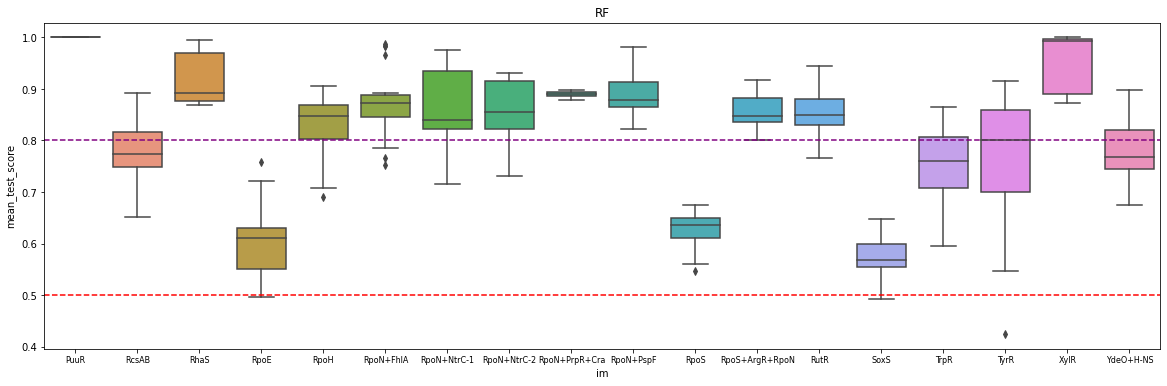

In [33]:
hyperopt_RF_df_3=pd.read_csv('data/hyperopt_RF_3.csv')
plt.figure( figsize=(20,6))
#sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_RF_df_3)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_RF_df_3)
plt.axhline(y= 0.8, color = 'purple', ls = '--')
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.xticks(fontsize=8)
plt.title('RF')

# Error analysis generate TP,TN,FP,FN labels

In [9]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [10]:
validation = pd.DataFrame(list(zip(features['ID'])), columns =['ID'] )

In [11]:
best_models_0 = {
     'AraC/AllR/FucR':RFC(n_estimators=100,max_depth=11,min_samples_split=0.005,min_samples_leaf=12,class_weight='balanced',verbose=1),
    'ArcA-1':RFC(n_estimators=200,max_depth=5,min_samples_split=0.009,min_samples_leaf=8,class_weight='balanced',verbose=1),
    'ArgR':RFC(n_estimators=200,max_depth=5,min_samples_split=0.001,min_samples_leaf=6,class_weight='balanced',verbose=1),
    'ArgP':RFC(n_estimators=60,max_depth=5,min_samples_split=0.019,min_samples_leaf=12,class_weight='balanced',verbose=1),
    'DhaR/Mlc':RFC(n_estimators=60,max_depth=6,min_samples_split=0.018,min_samples_leaf=7,class_weight='balanced',verbose=1),
    'Cbl+CysB':RFC(n_estimators=120,max_depth=10,min_samples_split=0.003,min_samples_leaf=9,class_weight='balanced',verbose=1),
    'CpxR':RFC(n_estimators=60,max_depth=4,min_samples_split=0.009,min_samples_leaf=5,class_weight='balanced',verbose=1),
    'CdaR':RFC(n_estimators=50,max_depth=4,min_samples_split=0.015,min_samples_leaf=8,class_weight='balanced',verbose=1),
    'Cra':RFC(n_estimators=200,max_depth=9,min_samples_split=0.002,min_samples_leaf=14,class_weight='balanced',verbose=1),
    'EvgA':RFC(n_estimators=110,max_depth=11,min_samples_split=0.013,min_samples_leaf=14,class_weight='balanced',verbose=1),
    'CysB-1':RFC(n_estimators=190,max_depth=11,min_samples_split=0.011,min_samples_leaf=6,class_weight='balanced',verbose=1),
    'CysB-2':RFC(n_estimators=170,max_depth=12,min_samples_split=0.019,min_samples_leaf=9,class_weight='balanced',verbose=1)
}

In [12]:
for im in best_models_0.keys():
    train = list(target_labels[im])
    test = list(best_models_0[im].fit(X,train).predict(X))
    assess = []
    for i in range(len(train)):
        if train[i] == test[i]:
            if train[i] == 1:
                assess.append('TP')
            else:
                assess.append('TN')
        else:
            if train[i] == 1:
                assess.append('FN')
            else:
                assess.append('FP')
    validation[im+' train'] = train
    validation[im+' test'] = test
    validation[im+ ' assess'] = assess

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [13]:
validation

,ID,AraC/AllR/FucR train,AraC/AllR/FucR test,AraC/AllR/FucR assess,ArcA-1 train,ArcA-1 test,ArcA-1 assess,ArgR train,ArgR test,ArgR assess,...,Cra assess,EvgA train,EvgA test,EvgA assess,CysB-1 train,CysB-1 test,CysB-1 assess,CysB-2 train,CysB-2 test,CysB-2 assess
0,b0008,0,0,TN,0,0,TN,0,0,TN,...,TN,0,0,TN,0,0,TN,0,0,TN
1,b0025,0,0,TN,0,0,TN,0,0,TN,...,TN,0,0,TN,0,0,TN,0,0,TN
2,b0034,0,0,TN,0,0,TN,0,0,TN,...,TN,0,0,TN,0,0,TN,0,0,TN
3,b0035,0,0,TN,0,0,TN,0,0,TN,...,TN,0,0,TN,0,0,TN,0,0,TN
4,b0036,0,0,TN,0,0,TN,0,0,TN,...,TN,0,0,TN,0,0,TN,0,0,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,b4504,0,0,TN,0,0,TN,0,0,TN,...,TN,0,0,TN,0,0,TN,0,0,TN
2590,b4616,0,0,TN,0,0,TN,0,0,TN,...,TN,0,0,TN,0,0,TN,0,0,TN
2591,b4637,0,0,TN,0,0,TN,0,0,TN,...,TN,0,0,TN,0,0,TN,0,0,TN
2592,b4669,0,0,TN,0,0,TN,0,0,TN,...,TN,0,0,TN,0,0,TN,0,0,TN


In [14]:
validation.to_csv('data/validation_0.csv')

(0.0, 60.0)

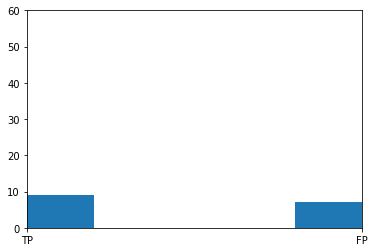

In [43]:
plt.hist(  validation['CysB-1 assess'])
plt.xlim(['TP','FP'])
plt.ylim([0,60])

(0.0, 25.0)

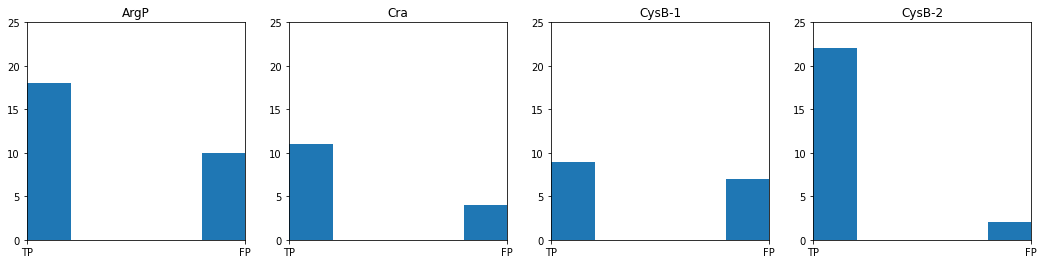

In [48]:
#ArgP,CysB-1,2
fig,( ax0,ax1,ax2,ax3) = plt.subplots(ncols=4, figsize=(18,4))
ax0.hist(validation['ArgP assess'])
ax0.set_title('ArgP')
ax0.set_xlim(['TP','FP'])
ax0.set_ylim([0,25])
ax1.hist(validation['Cra assess'])
ax1.set_title('Cra')
ax1.set_xlim(['TP','FP'])
ax1.set_ylim([0,25])
ax2.hist(validation['CysB-1 assess'])
ax2.set_title('CysB-1' )
ax2.set_xlim(['TP','FP'])
ax2.set_ylim([0,25])
ax3.hist(validation['CysB-2 assess'])
ax3.set_title('CysB-2' )
ax3.set_xlim(['TP','FP'])
ax3.set_ylim([0,25])

In [45]:
tf_list = ['AraC', 'ArcA', 'ArgP', 'ArgR', 'CysB', 'CpxR', 'Cra', 
           'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
           'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
           'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 
           'Nac', 'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OxyR', 'PhoB', 'PhoP', 
           'PurR', 'PuuR', 'RcsAB', 'RhaS', 'SoxS', 'TrpR', 'XylR']

regulon_genes={}
for TF in bitome.transcription_factors:
    if TF.name in tf_list:
        regulon_genes[TF.name] = []   
        for r in TF.regulons:
                for p in list(r.regulated_promoters.values())[0]:
                    if p.transcription_unit != None and len(p.transcription_unit.genes)>0:
                        for g in p.transcription_unit.genes:
                            regulon_genes[TF.name].append( g.locus_tag)

In [46]:
FP = {}
for im in best_models_0.keys():
    FP[im] = []
    for i in range(len(validation[im+ ' assess'])):
        if validation[im+ ' assess'][i] == 'FP':
            FP[im].append( validation['ID'][i])  

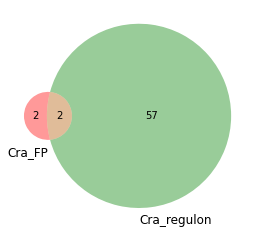

In [56]:
from matplotlib_venn import venn2
venn2([set(FP['Cra']),set(regulon_genes['Cra'])],set_labels = ('Cra_FP','Cra_regulon'))
plt.show()

# bad models

In [65]:
badmodels = ['AppY-1','AppY-2','Copper','CsqR','FecI','Fnr','GadWX','GcvA',
             'GlcC','NikR','PrpR','Pyruvate','RbsR','SrlR+GutM',
             'Thiamine','YgbI','YieP','YneJ']

In [66]:
bad_imcount={}
for im in badmodels:
    bad_imcount[im] = len(IM_genes[im])

bad_imcount_data = {}
for im in badmodels:
    bad_imcount_data[im] = 0

for im in bad_imcount_data.keys():
    for g in ID:
        if g in IM_genes[im]:
            bad_imcount_data[im] += 1

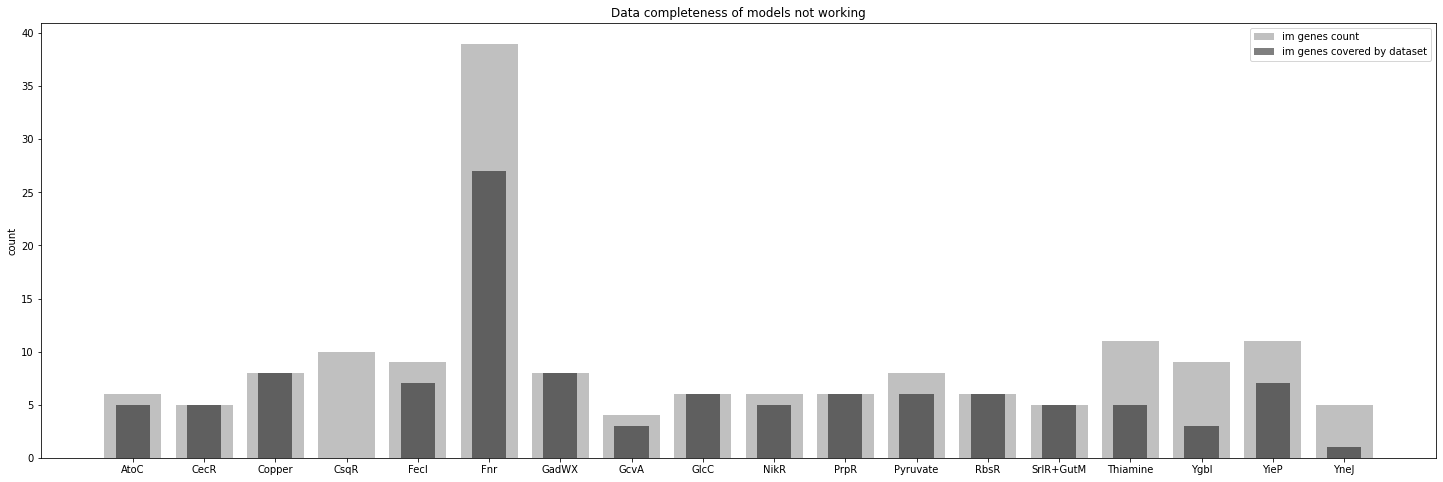

In [67]:
plt.figure(figsize=(25,8))
plt.bar(list(bad_imcount.keys()), list(bad_imcount.values()), width=0.8, 
        color='silver', label='im genes count')

plt.bar( list(bad_imcount_data.keys()), list(bad_imcount_data.values()), 
        width=0.6*0.8, color='black', alpha=0.5, label='im genes covered by dataset')

plt.xticks( list(bad_imcount.keys()) )
plt.ylabel('count')
plt.legend()
plt.title('Data completeness of models not working')
plt.show()

## meme fasta 

In [11]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [12]:
bTog = {}
for g in bitome.genes:
    bTog[g.locus_tag] = g.name
    
def revstrand(inseq):
    outseq=inseq[::-1]
    return outseq

def complement(inseq):
    inseq.upper()
    clist=[]
    for ntide in inseq:
        if ntide == 'A':
            clist.append('T')
        if ntide == 'C':
            clist.append('G')
        if ntide == 'G':
            clist.append('C')
        if ntide == 'T':
            clist.append('A')
    complement=''.join(clist)
    return complement

In [22]:
GalRGalS_genes=[]
for b in IM_genes['GalR+GalS']:
    GalRGalS_genes.append(bTog[b])
    
GalRGalS_records=[]
for g in GalRGalS_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        GalRGalS_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [23]:
SeqIO.write(GalRGalS_records,'MEME_results/GalRGalS/GalRGalS.fasta','fasta')

35

In [31]:
nac_genes=[]
for b in IM_genes['Nac']:
    nac_genes.append(bTog[b])
    
nac_records=[]
for g in nac_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        nac_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [32]:
SeqIO.write(nac_records,'GLAM2_results/Nac/nac.fasta','fasta')

42

soxs_genes=[]
soxs_im = list(IM_genes['SoxS'])
soxs_im.remove('b4744')
for b in soxs_im:
    soxs_genes.append(bTog[b])
    
soxs_records=[]
for g in soxs_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        soxs_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [14]:
soxs_bs = pd.read_csv('data/SoxSTFBS_PMID26279566.txt', sep=" ", header=None)
soxs_postuples = []
for pos_tup in soxs_bs[0]:
    pos_tuple = pos_tup.split('\t')
    soxs_postuples.append( (int(pos_tuple[0]), int(pos_tuple[1]),int(pos_tuple[2]))  )
    
soxs_recs=[]
soxs_temp = []
for strand, left, right in soxs_postuples:
    mid = int( (left+right)/2 )
    if strand == 1:
        s = str(bitome.sequence[left: right])
        temps =   str(bitome.sequence[mid - 50 : mid + 50 ])
    else:
        s = str( complement(revstrand( str(bitome.sequence)[left:right] )) )
        temps = str( complement(revstrand( str(bitome.sequence)[mid - 50: mid + 50] )) )
        
    if len(s) == 32:
        soxs_temp.append(str(s))
    soxs_recs.append(  SeqRecord(  Seq( temps ) , id ='pos_'+str(left)+'_'+str(right), name ='', description='') )
    
SeqIO.write(soxs_recs,'MEME_results/SoxS/soxs_chip.fasta','fasta')

26

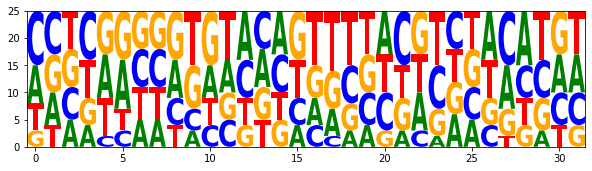

In [13]:
import logomaker as lm
counts_mat = lm.alignment_to_matrix( soxs_temp )
lm.Logo(counts_mat)

In [22]:
SeqIO.write(soxs_records,'MEME_results/SoxS/soxs.fasta','fasta')

125

In [24]:
cpxr_genes=[]
CpxR_im = list(IM_genes['CpxR'])
CpxR_im.remove('b4751')
for b in CpxR_im:
    cpxr_genes.append(bTog[b])
    
cpxr_records=[]
for g in cpxr_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        cpxr_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [25]:
SeqIO.write(cpxr_records,'MEME_results/CpxR/cpxr.fasta','fasta')

52

In [37]:
cra_genes=[]
for b in IM_genes['Cra']:
    cra_genes.append(bTog[b])
    
cra_records=[]
for g in cra_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
        cra_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [38]:
SeqIO.write(cra_records,'MEME_results/Cra/cra.fasta','fasta')

25

In [39]:
yiaj_genes = []
for b in IM_genes['YiaJ']:
    yiaj_genes.append(bTog[b])
    
yiaj_records=[]
for g in yiaj_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        yiaj_records.append(  SeqRecord(Seq(s), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [40]:
SeqIO.write(yiaj_records,'MEME_results/YiaJ/yiaj.fasta','fasta')

19

In [42]:
TyrR_genes = []
for b in IM_genes['TyrR']:
    TyrR_genes.append(bTog[b])
    
TyrR_records=[]
for g in TyrR_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        TyrR_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [43]:
SeqIO.write(TyrR_records,'MEME_results/TyrR/TyrR.fasta','fasta')

15

In [13]:
fnr2_genes = []
fnr2_im = list(IM_genes['Fnr-2'])
fnr2_im.remove('b4752')
for b in fnr2_im:
    fnr2_genes.append(bTog[b])
    
fnr2_records=[]
for g in fnr2_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        fnr2_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [14]:
SeqIO.write(fnr2_records,'MEME_results/Fnr-2/Fnr-2.fasta','fasta')

55

In [19]:
fnr1_genes = []
fnr1_im = list(IM_genes['Fnr-1'])
fnr1_im.remove('b4756')
fnr1_im.remove('b4589')
for b in fnr1_im:
    fnr1_genes.append(bTog[b])
    
fnr1_records=[]
for g in fnr1_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        fnr1_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [20]:
SeqIO.write(fnr1_records,'MEME_results/Fnr-1/Fnr-1.fasta','fasta')

35

In [51]:
argp_genes = []
argp_im = list(IM_genes['ArgP'])
argp_im.remove('b4756')

for b in argp_im:
    argp_genes.append(bTog[b])
    
argp_records=[]
for g in argp_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        argp_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [52]:
SeqIO.write(argp_records,'MEME_results/ArgP/ArgP.fasta','fasta')

35

In [55]:
cysb2_genes = []
cysb2_im = list(IM_genes['CysB-2'])
cysb2_im.remove('b4720')
cysb2_im.remove('b4721')
for b in cysb2_im:
    cysb2_genes.append(bTog[b])
    
cysb2_records=[]
for g in cysb2_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        cysb2_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [56]:
SeqIO.write(cysb2_records,'MEME_results/CysB-2/CysB-2.fasta','fasta')

24

In [28]:
arca1_genes = []
arca1_im = list(IM_genes['ArcA-1'])
arca1_im.remove( 'b4735' )
for b in arca1_im:
    arca1_genes.append(bTog[b])
    
arca1_records=[]
for g in arca1_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        arca1_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [29]:
SeqIO.write(arca1_records,'MEME_results/ArcA-1/ArcA-1.fasta','fasta')

45

In [31]:
arca2_genes = []
arca2_im = list(IM_genes['ArcA-2'])
for b in arca2_im:
    arca2_genes.append(bTog[b])
    
arca2_records=[]
for g in arca2_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        arca2_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [32]:
SeqIO.write(arca2_records,'MEME_results/ArcA-2/ArcA-2.fasta','fasta')

42

In [33]:
oxyr_genes = []
oxyr_im = list(IM_genes['OxyR'])
for b in oxyr_im:
    oxyr_genes.append(bTog[b])
    
oxyr_records=[]
for g in oxyr_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        oxyr_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [34]:
SeqIO.write(  oxyr_records,'MEME_results/OxyR/OxyR.fasta','fasta')

27

In [36]:
lrp_genes = []
lrp_im = list(IM_genes['Lrp'])
lrp_im.remove('b4740')
for b in lrp_im:
    lrp_genes.append(bTog[b])
    
lrp_records=[]
for g in lrp_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        lrp_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [37]:
SeqIO.write(  lrp_records,'MEME_results/Lrp/Lrp.fasta','fasta')

39

In [38]:
nagc_genes = []
nagc_im = list(IM_genes['NagC'])
for b in nagc_im:
    nagc_genes.append(bTog[b])
    
nagc_records=[]
for g in nagc_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        nagc_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [39]:
SeqIO.write(  nagc_records,'MEME_results/NagC/NagC.fasta','fasta')

22

In [42]:
phop_genes = []
phop_im = list(IM_genes['PhoP'])
phop_im.remove( 'b4736' )
phop_im.remove( 'b4751' )
for b in phop_im:
    phop_genes.append(bTog[b])
    
phop_records=[]
for g in phop_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        phop_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [43]:
SeqIO.write( phop_records ,'MEME_results/PhoP/PhoP.fasta','fasta')

18

In [ ]:
fur1_genes = []
fur1_im = list(IM_genes['Fur-1'])
for b in fur1_im:
    fur1_genes.append(bTog[b])
    
fur1_records=[]
for g in fur1_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        fur1_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [ ]:
SeqIO.write(  fur1_records,'MEME_results/Fur-1/Fur-1.fasta','fasta')

In [ ]:
fur2_genes = []
fur2_im = list(IM_genes['Fur-2'])
for b in fur2_im:
    fur2_genes.append(bTog[b])
    
fur2_records=[]
for g in fur2_genes:
    gene = bitome.get_gene(g)
    if len(gene.transcription_units)<1:
        continue
    
    for i in range(len(gene.transcription_units) ):
        tu = gene.transcription_units[i] 
        if tu.promoter == None:
            continue
        TSS=tu.tss
        if tu.location.strand != -1:
            left = TSS-150
            right = TSS+30
            s = str(bitome.sequence)[left:right]
        else:
            left = TSS-30
            right = TSS+150
            s = complement(revstrand( str(bitome.sequence)[left:right] ))
            
        fur2_records.append(  SeqRecord(Seq( s ), id = gene.name+'_TU_'+str(i), name = tu.name, description='') )

In [ ]:
SeqIO.write(  fur2_records,'MEME_results/Fur-2/Fur-2.fasta','fasta')